# Prevedere l'età del granchio in base ai suoi attributi fisici

Progetto di Programmazione di Applicazioni Data Intensive - 2023/2024

**Realizzato da:** Simone Bollini  simone.bollini@studio.unibo.it mat. 0000

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Prevedere l'età del granchio

- Il set di dati viene utilizzato per stimare l'età del granchio in base agli attributi fisici.
Il granchio è molto gustoso e molti paesi del mondo importano ogni anno enormi quantità di granchi per il consumo.
I principali vantaggi dell'agricoltura del granchio sono che il costo del lavoro è molto basso, il costo di produzione è relativamente più basso e crescono molto velocemente. L'attività commerciale di allevamento di granchi sta sviluppando lo stile di vita della popolazione delle aree costiere.
Con un'adeguata cura e gestione possiamo guadagnare di più dalle attività di allevamento di granchi rispetto all'agricoltura di gamberetti.
Per un allevatore di granchi commerciale conoscere l'età giusta del granchio li aiuta a decidere se e quando raccogliere i granchi.
Oltre una certa età, c'è una crescita trascurabile delle caratteristiche fisiche del granchio e, quindi, è importante cronometrare la raccolta per ridurre i costi e aumentare i profitti.fitti.

## Estrazione dati

Il dataset puo essere scaricato da [Kaggle](https://www.kaggle.com/datasets/sidhus/crab-age-prediction/data) 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [15]:
import os.path
from urllib.request import urlretrieve
if not os.path.exists("crab.zip"):
    urlretrieve("https://github.com/ilBollo/DataIntensive_Project_Crab/raw/master/crab.zip", "crab.zip")


In [16]:
data = pd.read_csv("crab.zip", sep=",", compression="zip")
data.head()

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6


### Significato delle colonne
Le feature presenti nel dataset sono: 
- `Sex`: genere del granchio. Possibili valori: Female, Male o Indeterminate
- `Length`: Lunghezza del granchio (in piedi; 1 piede = 30,48 cm)
- `Diameter`: Diametro del granchio (in piedi; 1 piede = 30,48 cm)
- `Height`: Altezza del granchio (in piedi; 1 piede = 30,48 cm)
- `Weight`: Peso del granchio (in once; 1 sterlina = 16 once)
- `Shucked Weight`: Peso senza guscio (in once; 1 libbra = 16 once)
- `Viscera Weight`: è il peso che avvolge gli organi addominali nel profondo del corpo (in once; 1 libbra = 16 once)
- `Shell Weight`: Peso della conchiglia (in once; 1 sterlina = 16 once)
- `Age`: Età del granchio (in mesi)

La variabile che tenteremo di predirre è l'età del granchio.

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             3893 non-null   object 
 1   Length          3893 non-null   float64
 2   Diameter        3893 non-null   float64
 3   Height          3893 non-null   float64
 4   Weight          3893 non-null   float64
 5   Shucked Weight  3893 non-null   float64
 6   Viscera Weight  3893 non-null   float64
 7   Shell Weight    3893 non-null   float64
 8   Age             3893 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 273.9+ KB


la colonna sex contiene solo i valori "F", "M" e "I" per questo motivo occupa troppo spazio come object la ricarichiamo come tipo category per ottimizzare il consumo di memoria

In [22]:
data = pd.read_csv("crab.zip", sep=",", compression="zip", dtype={"Sex":"category"})

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Sex             3893 non-null   category
 1   Length          3893 non-null   float64 
 2   Diameter        3893 non-null   float64 
 3   Height          3893 non-null   float64 
 4   Weight          3893 non-null   float64 
 5   Shucked Weight  3893 non-null   float64 
 6   Viscera Weight  3893 non-null   float64 
 7   Shell Weight    3893 non-null   float64 
 8   Age             3893 non-null   int64   
dtypes: category(1), float64(7), int64(1)
memory usage: 247.4 KB


anche se il dataset non è molto grande solo questa piccola correzione ha ridotto l'uso di memoria quasi del 10%

## Analisi generale dei dati

Visualizziamo alcune statistiche per prendere coscienza dei dati che dovremo analizzare e delle caratteristiche del dominio applicativo.

Vediamo come prima cosa quanto variano i dati in nostro possesso:

In [26]:
for col in [x for x in data.columns if x != 'Sex']:
    print(col + ": \t" + str(data[col].nunique()))

Length: 	134
Diameter: 	111
Height: 	51
Weight: 	2343
Shucked Weight: 	1482
Viscera Weight: 	867
Shell Weight: 	907
Age: 	28


In [34]:
def plot_bar(feature, n, title):
    # Controllare il numero di valori unici nella colonna
    unique_values_count = data[feature].nunique()
    
    # Se il numero di valori unici è minore di n, impostare n al numero massimo di valori unici
    n = min(n, unique_values_count)
    
    # Tracciare il grafico a barre
    data[feature].value_counts().head(n).plot.bar(figsize=(15, 4))
    plt.gca().set_title(title)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

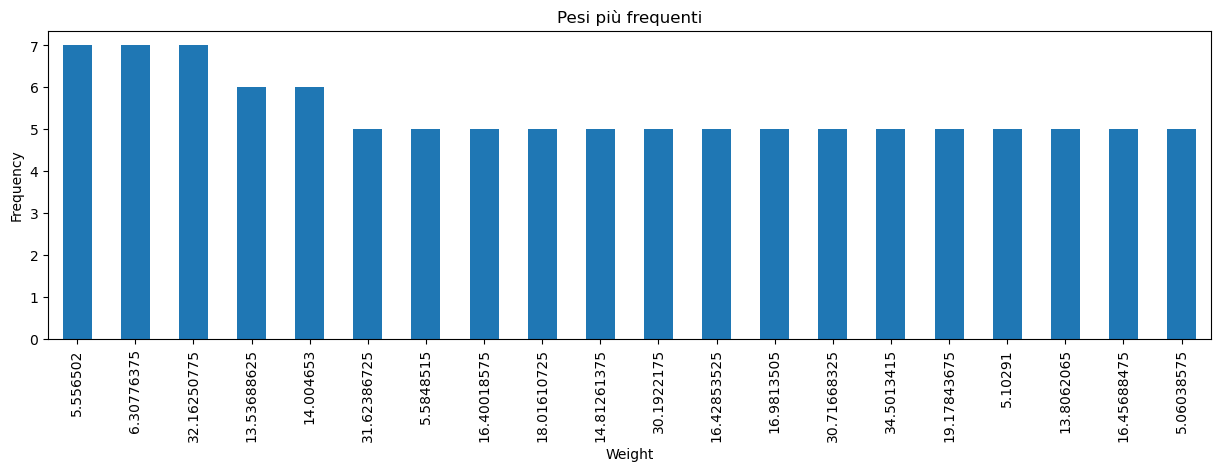

In [35]:
plot_bar("Weight", 20, "Pesi più frequenti")